In [1]:
import subprocess
import shlex
import re
import json

import numpy as np
import multiprocessing as mp

from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm
from IPython.display import display, Markdown
from tempfile import TemporaryDirectory

In [2]:
import scipy.special as sp

def s_island(A_eff, deme, nu):
    theta_A_eff = (deme * A_eff - 1.0) * nu / (1.0 - nu)
    
    return theta_A_eff * (sp.digamma(theta_A_eff + deme * A_eff) - sp.digamma(theta_A_eff))

def s_island_limit(A_eff, deme, nu):
    return ((A_eff * deme - 1.0) * nu * np.log(1.0 / nu)) / (1.0 - nu)

In [3]:
BIODIVERSITY_PATTERN = re.compile(r"The simulation resulted in a biodiversity of (\d+) unique species\.")
TIMING_PATTERN = re.compile(r"The simulation finished at time (\d+\.\d+) after (\d+) steps\.")

In [4]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [5]:
def simulate_non_spatial_monolithic(algorithm, speciation=0.1, seed=42, size=(10, 10, 10), spatial=False):
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: 1.0,
        seed: {seed},

        algorithm: {algorithm},

        log: None,

        scenario: NonSpatial(
            area: ({size[0]}, {size[1]}),
            deme: {size[2]},
            spatial: {str(spatial).lower()},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + "rustcoalescence-algorithms-independent,necsim-partitioning-mpi "
        + f"--quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    if match is None:
        print(result.stdout)
        print(result.stderr)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    if match is None:
        print(result.stdout)
        print(result.stderr)
    time = float(match.group(1))
    steps = int(match.group(2))
        
    return biodiversity, time, steps

In [6]:
def simulate_non_spatial_parallel(algorithm, partitions=4, speciation=0.1, seed=42, size=(10, 10, 10), spatial=False):
    with TemporaryDirectory() as log:
        config = "".join(f"""
        (
            speciation: {speciation},
            sample: 1.0,
            seed: {seed},

            algorithm: {algorithm},

            log: "{log}",

            scenario: NonSpatial(
                area: ({size[0]}, {size[1]}),
                deme: {size[2]},
                spatial: {str(spatial).lower()},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                    reporters: [Biodiversity()]
                )
            ],
        )
        """.split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        result = subprocess.run(shlex.split(
            "cargo mpirun --release --features rustcoalescence-algorithms-monolithic,"
            + "rustcoalescence-algorithms-independent,necsim-partitioning-mpi --bin rustcoalescence "
            + f"-n {partitions} -- simulate '{config}'"
        ), capture_output=True, text=True)
        
        match = TIMING_PATTERN.search(result.stdout)
        if match is None:
            print(result.stdout)
            print(result.stderr)
        time = float(match.group(1))
        steps = int(match.group(2))
        
        config = "".join(f"""
        (
            logs: ["{log}/*/*"],

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                    reporters: [Biodiversity()]
                )
            ],
        )
        """.split()).replace(",)", ")").replace(",]", "]")
        
        # Run the simulation
        result = subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent,necsim-partitioning-mpi --quiet -- replay '{config}'"
        ), check=True, capture_output=True, text=True)

        match = BIODIVERSITY_PATTERN.search(result.stdout)
        if match is None:
            print(result.stdout)
            print(result.stderr)
        biodiversity = int(match.group(1))
        
    return biodiversity, time, steps

In [7]:
def simulate_non_spatial_isolated(algorithm, partitions=4, speciation=0.1, seed=42, size=(10, 10, 10), spatial=False):
    with TemporaryDirectory() as log:
        def simulate_non_spatial_isolated_partition(rank):
            config = "".join(f"""
            (
                speciation: {speciation},
                sample: 1.0,
                seed: {seed},

                algorithm: {algorithm.format(partition=f'Partition(rank:{rank},partitions:{partitions})')},

                log: "{log}/{rank}",

                scenario: NonSpatial(
                    area: ({size[0]}, {size[1]}),
                    deme: {size[2]},
                    spatial: {str(spatial).lower()},
                ),

                reporters: [
                    Plugin(
                        library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                        reporters: [Biodiversity()]
                    )
                ],
            )
            """.split()).replace(",)", ")").replace(",]", "]")
            
            # Run the simulation
            result = subprocess.run(shlex.split(
                "cargo run --release --features rustcoalescence-algorithms-monolithic,"
                + "rustcoalescence-algorithms-independent,necsim-partitioning-mpi "
                + f"-- simulate '{config}'"
            ), capture_output=True, text=True)
        
            match = TIMING_PATTERN.search(result.stdout)
            if match is None:
                print(result.stdout)
                print(result.stderr)
            time = float(match.group(1))
            steps = int(match.group(2))
            
            return time, steps

        results = [simulate_non_spatial_isolated_partition(rank) for rank in range(partitions)]
            
        times, steps = tuple(zip(*results))
        
        config = "".join(f"""
        (
            logs: ["{log}/*/*/*"],

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                    reporters: [Biodiversity()]
                )
            ],
        )
        """.split()).replace(",)", ")").replace(",]", "]")
        
        # Run the simulation
        result = subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent,necsim-partitioning-mpi --quiet -- replay '{config}'"
        ), check=True, capture_output=True, text=True)

        match = BIODIVERSITY_PATTERN.search(result.stdout)
        if match is None:
            print(result.stdout)
            print(result.stderr)
        biodiversity = int(match.group(1))
        
    return biodiversity, max(times), sum(steps)

In [8]:
def batch_simulation_many_seeds(simulate, seeds, args=tuple(), kwargs=dict(), silent=False, processes=mp.cpu_count()):
    results = []

    with tqdm(total=len(seeds), disable=silent) as progress:
        def update_progress(result):
            results.append(result)

            progress.update()
        
        def update_error(err):
            print(err)

        with mp.Pool(processes) as pool:
            for seed in seeds:
                pool.apply_async(simulate, args, {**kwargs, "seed": seed}, update_progress, update_error)

            pool.close()
            pool.join()
    
    return results

In [9]:
def confidenceInterval(a, conf=0.95):
    mean = np.mean(a)
    sem = stats.sem(a)
    
    t = stats.t.ppf((1.0 + conf) * 0.5, len(a) - 1)
    
    return mean - t*sem, mean + t*sem

In [10]:
def visualise_biodiversity_time_steps_result(expected, biodiversities, times, steps, conf=0.95):
    low, high = confidenceInterval(biodiversities, conf=conf)

    xmin = np.min(biodiversities)
    xmax = np.max(biodiversities)

    bins = min(21, xmax - xmin + (1 - (xmax - xmin) % 2))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

    ax1.set_title("Biodiversity distribution")
    ax1.set_xlabel("biodiversity")
    ax1.set_ylabel("pdf")
    ax1.hist(biodiversities, bins=bins, density=True, label=(
        f"Observed: {round((low + high) * 0.5, 2)} ± {round((high - low) * 0.5, 2)} ({conf} level)"
    ))
    ax1.axvline(x=expected, color='red', label=f"Expected: {round(expected, 2)}")

    mu, std = stats.norm.fit(biodiversities)
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax1.plot(x, p, 'k', linewidth=2, label=f"Fitted: mu≈{round(mu, 2)} sigma≈{round(std, 2)}")

    ax1.legend(loc = 'lower center')

    ax2.set_title("Simulation time distribution")
    ax2.set_xlabel("time")
    ax2.set_ylabel("pdf")
    ax2.hist(times, bins=bins, density=True)

    ax3.set_title("Simulation steps distribution")
    ax3.set_xlabel("steps")
    ax3.set_ylabel("pdf")
    ax3.hist(steps, bins=bins, density=True)

    plt.show()

# I. Verify that different `delta_t`s for the Independent Algorithm give the correct results for a NonSpatial scenario

100%|██████████| 1000/1000 [05:45<00:00,  2.89it/s]


## Independent(delta_t:0.5):

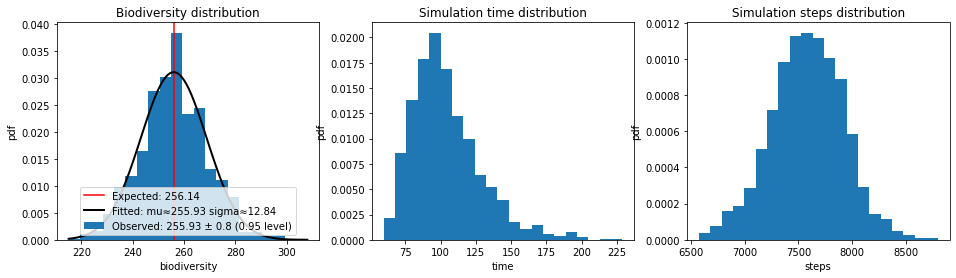

100%|██████████| 1000/1000 [01:13<00:00, 13.57it/s]


## Independent(delta_t:5.0):

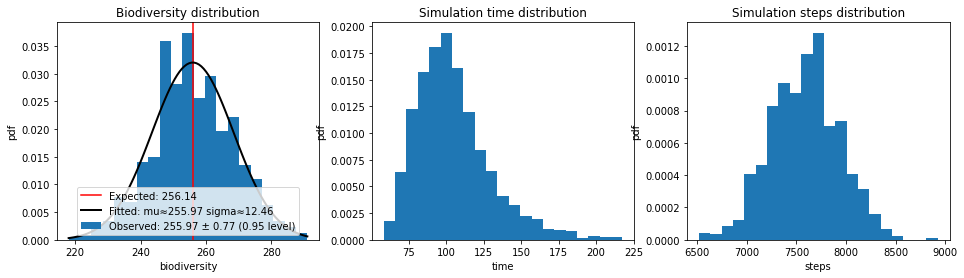

In [11]:
for algorithm in ["Independent(delta_t:0.5)", "Independent(delta_t:5.0)"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

    results = batch_simulation_many_seeds(simulate_non_spatial_monolithic, seeds, args=(algorithm,), kwargs={
        "size":(10, 10, 10), "speciation":0.1
    }, silent=False)

    biodiversities, times, steps = tuple(zip(*results))

    display(Markdown(f"## {algorithm}:"))
    visualise_biodiversity_time_steps_result(s_island(10*10, 10, 0.1), biodiversities, times, steps)

# II. Verify that the default settings for the Independent Algorithm give the correct results for a NonSpatial scenario without parallelisation

100%|██████████| 1000/1000 [01:13<00:00, 13.67it/s]


## Independent():

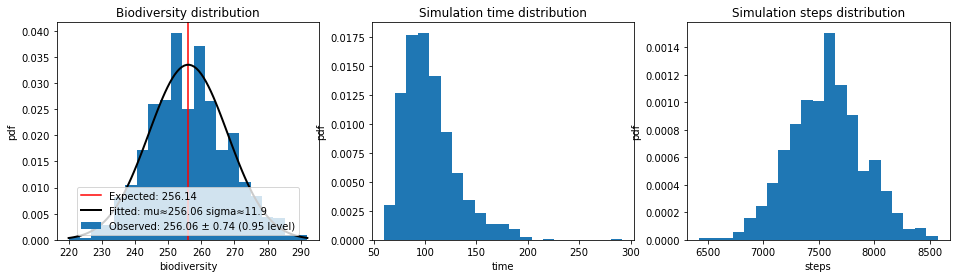

In [12]:
for algorithm in ["Independent()"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

    results = batch_simulation_many_seeds(simulate_non_spatial_monolithic, seeds, args=(algorithm,), kwargs={
        "size":(10, 10, 10), "speciation":0.1
    }, silent=False)

    biodiversities, times, steps = tuple(zip(*results))

    display(Markdown(f"## {algorithm}:"))
    visualise_biodiversity_time_steps_result(s_island(10*10, 10, 0.1), biodiversities, times, steps)

# III. Verify that the non-altering settings produce exactly the same results (excluding #steps)

In [13]:
comparison_seeds = seeds[:]
comparison_results = sorted(r[:2] for r in results[:])

for algorithm in [
    "Independent(step_slice:1)", "Independent(step_slice:25)",
    "Independent(dedup_cache:Absolute(capacity:10))", "Independent(dedup_cache:None)",
    "Independent(parallelism_mode:Monolithic(event_slice:1000))", "Independent(parallelism_mode:Monolithic(event_slice:1))",
]:
    check_results = batch_simulation_many_seeds(simulate_non_spatial_monolithic, comparison_seeds, args=(algorithm,), kwargs={
        "size":(10, 10, 10), "speciation":0.1
    }, silent=False)
    
    check_results = sorted(r[:2] for r in check_results)
    
    if check_results == comparison_results:
        display(Markdown(f"## {algorithm}: <span style='color:green'>Success</span>"))
    else:
        display(Markdown(f"## {algorithm}: <span style='color:red'><u>FAILURE</u></span>"))

100%|██████████| 1000/1000 [01:13<00:00, 13.61it/s]


## Independent(step_slice:1): <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [01:14<00:00, 13.47it/s]


## Independent(step_slice:25): <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]


## Independent(dedup_cache:Absolute(capacity:10)): <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


## Independent(dedup_cache:None): <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [01:13<00:00, 13.52it/s]


## Independent(parallelism_mode:Monolithic(event_slice:1000)): <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]


## Independent(parallelism_mode:Monolithic(event_slice:1)): <span style='color:green'>Success</span>

# IV. Verify that the Monolithic replay analysis though the event log produces exactlty the same results as live analysis

In [14]:
comparison_seeds = seeds[:]
comparison_results = sorted(r[:2] for r in results[:])

for algorithm in ["Independent(parallelism_mode:Monolithic(event_slice:100))"]:
    check_results = batch_simulation_many_seeds(simulate_non_spatial_parallel, comparison_seeds, args=(algorithm,), kwargs={
        "partitions":1, "size":(10, 10, 10), "speciation":0.1
    }, silent=False)

    check_results = sorted(r[:2] for r in check_results)

    if check_results == comparison_results:
        display(Markdown(f"## {algorithm}: <span style='color:green'>Success</span>"))
    else:
        display(Markdown(f"## {algorithm}: <span style='color:red'><u>FAILURE</u></span>"))

100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s]


## Independent(parallelism_mode:Monolithic(event_slice:100)): <span style='color:green'>Success</span>

# V. Verify that the Isolated parallelisation produces exactly the same results

In [15]:
comparison_seeds = seeds[:]
comparison_results = sorted(r[:2] for r in results[:])

for algorithm in [
    "Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1))",
    "Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1000))",
    "Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1))",
    "Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1000))",
]:
    for partitions in [2, 5, 40]:
        check_results = batch_simulation_many_seeds(simulate_non_spatial_isolated, comparison_seeds, args=(algorithm,), kwargs={
            "partitions":partitions, "size":(10, 10, 10), "speciation":0.1
        }, silent=False)
        
        check_results = sorted(r[:2] for r in check_results)

        if check_results == comparison_results:
            display(Markdown(f"## {algorithm} with {partitions} partitions: <span style='color:green'>Success</span>"))
        else:
            display(Markdown(f"## {algorithm} with {partitions} partitions: <span style='color:red'><u>FAILURE</u></span>"))

100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1)) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [07:18<00:00,  2.28it/s]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1)) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [49:59<00:00,  3.00s/it]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1)) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1000)) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [07:18<00:00,  2.28it/s]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1000)) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [49:58<00:00,  3.00s/it]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1000)) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [03:39<00:00,  4.56it/s]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1)) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [07:19<00:00,  2.28it/s]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1)) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [50:03<00:00,  3.00s/it]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1)) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1000)) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [07:20<00:00,  2.27it/s]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1000)) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [50:01<00:00,  3.00s/it]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1000)) with 40 partitions: <span style='color:green'>Success</span>

# VI. Verify that the different parallelisation methods produce exactly the same results

In [16]:
comparison_seeds = seeds[:]
comparison_results = sorted(r[:2] for r in results[:])

for algorithm in [
    "Independent(parallelism_mode:Individuals)",
    "Independent(parallelism_mode:Landscape)",
    "Independent(parallelism_mode:Probabilistic)",
]:
    for partitions in [2, 5, 40]:
        check_results = batch_simulation_many_seeds(simulate_non_spatial_parallel, comparison_seeds, args=(algorithm,), kwargs={
            "partitions":partitions, "size":(10, 10, 10), "speciation":0.1
        }, silent=False, processes=(mp.cpu_count() // partitions))
        
        check_results = sorted(r[:2] for r in check_results)

        if check_results == comparison_results:
            display(Markdown(f"## {algorithm} with {partitions} partitions: <span style='color:green'>Success</span>"))
        else:
            display(Markdown(f"## {algorithm} with {partitions} partitions: <span style='color:red'><u>FAILURE</u></span>"))

100%|██████████| 1000/1000 [03:48<00:00,  4.37it/s]


## Independent(parallelism_mode:Individuals) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [03:52<00:00,  4.30it/s]


## Independent(parallelism_mode:Individuals) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [23:59<00:00,  1.44s/it]


## Independent(parallelism_mode:Individuals) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [03:48<00:00,  4.37it/s]


## Independent(parallelism_mode:Landscape) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]


## Independent(parallelism_mode:Landscape) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [24:08<00:00,  1.45s/it]


## Independent(parallelism_mode:Landscape) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


## Independent(parallelism_mode:Probabilistic) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [03:54<00:00,  4.27it/s]


## Independent(parallelism_mode:Probabilistic) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████| 1000/1000 [24:09<00:00,  1.45s/it]


## Independent(parallelism_mode:Probabilistic) with 40 partitions: <span style='color:green'>Success</span>